### Данные - Ирисы Фишера

В задаче будут рассмотрены две выборки из базы данных ирисов Фишера:
* Первая выборка формируется из 3 и 4 столбца признаков, а именно petalLength и 
petalWidht. Это позволит отобразить как результаты обучения, так и классификацию в двумерном пространстве. 
* Вторая выборка формируется из полного признакового описания объектов. По ней будет возможно отобразить лишь результаты обучения.

Также будет рассмотрена выборка, дающая лучший результат на геометрическом весе.

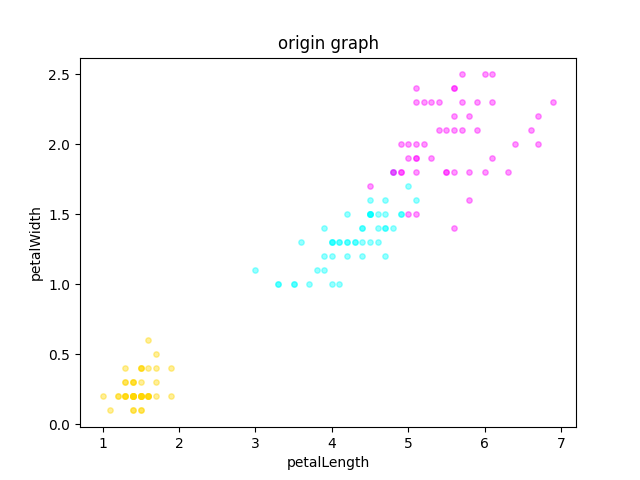

### Описание алгоритма

Метод k взешенных ближайших соседей представляет из себя метрический алгоритм классификации. Он относит объект к классу, для которого максимален суммарный вес ближайших обучающих объектов. Метрический в названии говорит о заданной функции расстояния или близости объектов. Функция веса определяется в зависимости от задачи и требований. В простейшем случае вес эквивалентен единице.

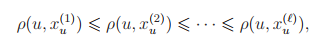

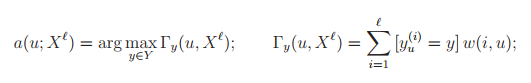

Шаги алгоритма:

*   Построить упорядоченное по близости к объекту множество соседей 
*   Рассчитать Г для каждого класса на основании множества соседей
*   Выбрать, для какого класса Г наибольшая

Полученный на последнем шаге класс и будет ответом.


Для обучения модели, то есть поиска ее оптимальных параметров, используется метод Leave-One-Out, который позволяет перебрать все возможные параметры и рассчитать на них ошибку. Параметры с минимальной ошибкой и будут решением задачи: 

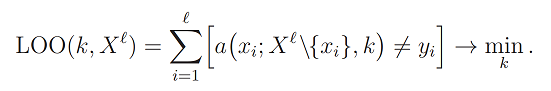

Аналогичным образом можно перебирать не только количество соседей, но и параметры для весов, что можно увидеть далее.

### Код программы

Все kNN подобные алгоритмы наследуются от одного абстрактного класса. Который позволяет переопределить функции расстояния, веса и метода обучения. На вход он получает объекты и соответствующие им ответы, количество соседей, и технический флаг о наличии в переданных данных названия колонок.

In [ ]:
from abc import ABC, abstractmethod
import pandas as pd


class AbstractKNeighborsMethod(ABC):
    _k: int
    _objects: list
    _answers: list
    answer_set: list
    _objects_neighbors: list

    gamma_data: dict
    current_neighbors: list

    def __init__(self, objects: pd.DataFrame, answers: pd.DataFrame, k, is_column_name=True):
        if is_column_name:
            objects.columns = objects.iloc[0]
            answers.columns = answers.iloc[0]
        self.objects = objects
        self.answers = answers
        self.k = k
        self.set_neighbors_for_objects()

    @property
    def k(self):
        return self._k

    @k.setter
    def k(self, val):
        if val <= 0:
            print("k must be > 0")
        self._k = val

    @property
    def objects(self):
        return self._objects

    @objects.setter
    def objects(self, val):
        self._objects = []
        for index, obj in val.iterrows():
            self._objects.append((index, tuple(obj.tolist())))

    @property
    def answers(self):
        return self._answers

    @answers.setter
    def answers(self, val):
        self._answers = []
        for _, answer in val.iterrows():
            self._answers.append(answer.tolist()[0])
        # Формирование упорядоченого множества
        self.answer_set = list(dict.fromkeys(self._answers))

    def set_neighbors_for_objects(self):
        self._objects_neighbors = []
        for obj in self.objects:
            self._objects_neighbors.append(self.neighbors(obj))

    def add_object_answer(self, new_object, new_answer, is_without_index=True):
        if is_without_index:
            new_object = (len(self.objects), new_object)
        self.objects.append(new_object)
        self.answers.append(new_answer)
        if not self.answers.__contains__(new_answer):
            self.answer_set.append(new_answer)

    def neighbors(self, u, is_new_element=False, cases_dict: dict = None):
        if cases_dict is None:
            temp_cases = self.objects.copy()
            if not is_new_element:
                del temp_cases[u[0]]
        else:
            temp_cases = cases_dict.copy()
            temp_cases.pop(u[0], None)
            temp_cases = list(temp_cases.values())
        return sorted(temp_cases, key=lambda obj: self.distance(u[1], obj[1]))

    def gamma(self, y, u, u_neighbors):
        l_neighbors = len(u_neighbors)
        neighbors_in_class_weight_sum = 0
        for i in range(self.k):
            if i >= l_neighbors:
                break
            if self.answers[u_neighbors[i][0]] == y:
                neighbors_in_class_weight_sum += self.weight(i + 1, u[1])
        return neighbors_in_class_weight_sum

    def classify(self, u, is_new_element=True, is_k_depend=False):
        if is_k_depend:
            if is_new_element:
                u = (len(self.objects), u)
                u_neighbors = self.neighbors(u, is_new_element)
            else:
                u_neighbors = self._objects_neighbors[u[0]]
        elif is_new_element:
            u = (len(self.objects), u)
            u_neighbors = self.neighbors(u, is_new_element)
        else:
            u_neighbors = self._objects_neighbors[u[0]]

        self.current_neighbors = u_neighbors
        max_gamma = -1
        arg_max = None
        for y in self.answer_set:
            if is_new_element or is_k_depend:
                gamma = self.gamma(y, u, u_neighbors)
            else:
                gamma = self.gamma_data[self.k][y][u[0]]
                new_gamma = gamma
                if self.k < len(u_neighbors):
                    if self.answers[u_neighbors[self.k][0]] == y:
                        new_gamma = gamma + self.weight(self.k, u[1])
                self.gamma_data[self.k + 1][y][u[0]] = new_gamma
            if gamma > max_gamma:
                max_gamma = gamma
                arg_max = y
        return arg_max

    def loo_sum(self, is_k_depend=False, objects_vargamma=None):
        is_vargamma_depend = objects_vargamma is not None
        if not is_k_depend:
            self.gamma_data[self.k + 1] = {}
            for y in self.answer_set:
                self.gamma_data[self.k + 1][y] = {}

        incorrect_object_answer = 0
        for x in self.objects:
            a = self.classify(x, False, is_k_depend)
            if a != self.answers[x[0]]:
                incorrect_object_answer += 1
                if is_vargamma_depend:
                    objects_vargamma[x[0]] += 1
        return incorrect_object_answer

    def gamma_data_init(self):
        origin_k = self.k
        self.k = 1
        self.gamma_data = {1: {}}
        for y in self.answer_set:
            self.gamma_data[1][y] = {}
            for obj in self.objects:
                self.current_neighbors = self._objects_neighbors[obj[0]]
                gamma = self.gamma(y, obj, self.current_neighbors)
                self.gamma_data[1][y][obj[0]] = gamma
        self.k = origin_k

    @abstractmethod
    def weight(self, i, u):
        pass

    @abstractmethod
    def distance(self, u, x):
        pass
    
    @abstractmethod
    def find_parameters_from_list(self, *args):
        pass

Реализация простейшего алгоритма k ближайших соседей:

In [ ]:
class KNearestNeighbors(AbstractKNeighborsMethod):
    def __init__(self, objects, answers, k, is_column_name=True):
        super().__init__(objects, answers, is_column_name)

    def find_parameters_from_list(self, k_list):
        origin_k = self.k
        res_array = []
        self.gamma_data_init()
        for k in k_list:
            self.k = k
            res_array.append((self.loo_sum() / len(self.objects), k))
        self.k = origin_k
        return res_array

    def distance(self, u, x):
        res = 0
        for i in range(len(u)):
            res += (x[i] - u[i]) * (x[i] - u[i])
        return res

    def weight(self, i, u):
        if i <= self.k:
            return 1
        else:
            return 0

В результате обучения возвращается массив пар (ошибка, параметры). Параметры, которым соответствует наименьшая ошибка и будут оптимальны.

Аналогична реализация метода с весами: 

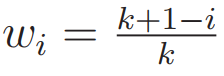

In [ ]:
class KWeightedNearestNeighbors(AbstractKNeighborsMethod):
    def __init__(self, objects, answers, k, is_column_name=True):
        super().__init__(objects, answers, k, is_column_name)

    def find_parameters_from_list(self, k_list):
        origin_k = self.k
        res_array = []
        for k in k_list:
            self.k = k
            res_array.append((self.loo_sum(is_k_depend=True) / len(self.objects), k))
        self.k = origin_k
        return res_array

    def distance(self, u, x):
        res = 0
        for i in range(len(u)):
            res += (x[i] - u[i]) * (x[i] - u[i])
        return res

    def weight(self, i, u):
        if i <= self.k:
            return (self.k + 1 - i) / self.k
        else:
            return 0

Реализация с весами, представляющими геометрическую прогрессию:

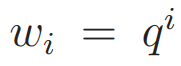

In [ ]:
class KWeightedNearestNeighborsGeometric(AbstractKNeighborsMethod):
    _q: float
    _q_power_list: list

    def __init__(self, objects, answers, k, q, is_column_name=True):
        super().__init__(objects, answers, k, is_column_name)
        self._q_power_list = self.find_powers_q(q)
        self.q = q

    @property
    def q(self):
        return self._q

    @q.setter
    def q(self, new_q):
        if new_q < 0 or new_q > 1:
            return
        self._q = new_q

    def find_parameters_from_list(self, k_list, q_list):
        origin_k = self.k
        origin_q = self.q
        origin_q_power_list = self._q_power_list
        res_array = []
        for q in q_list:
            self._q_power_list = self.find_powers_q(q)
            self.q = q
            self.gamma_data_init()
            for k in k_list:
                self.k = k
                res_array.append((self.loo_sum() / len(self.objects), k, q))

        self.k = origin_k
        self.q = origin_q
        self._q_power_list = origin_q_power_list
        return res_array

    def find_powers_q(self, q):
        q_power_list = []
        q_power = q
        for i in range(len(self.objects) + 2):
            q_power_list.append(q_power)
            q_power *= q
        return q_power_list

    def distance(self, u, x):
        res = 0
        for i in range(len(u)):
            res += (x[i] - u[i]) * (x[i] - u[i])
        return res

    def weight(self, i, u):
        return self._q_power_list[i]


### Результаты

#### К ближайших соседей

##### Параметры kNN для 2 признаков и карта классификации

График обучения:

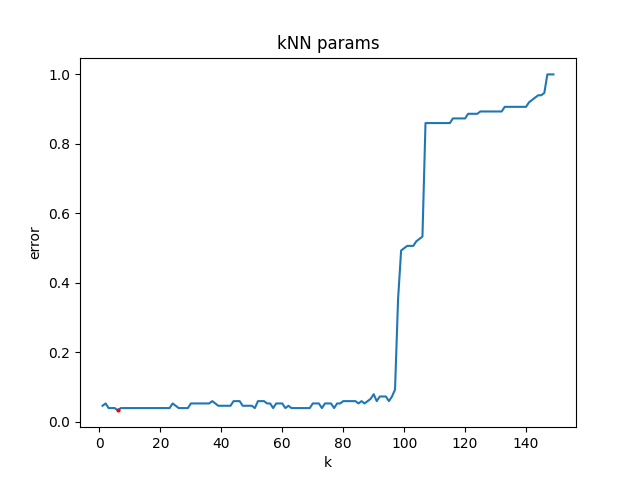

Минимальная ошибка достигается в точке (k = 6, error = 1/30)

Карта классификации для оптимальных параметров:

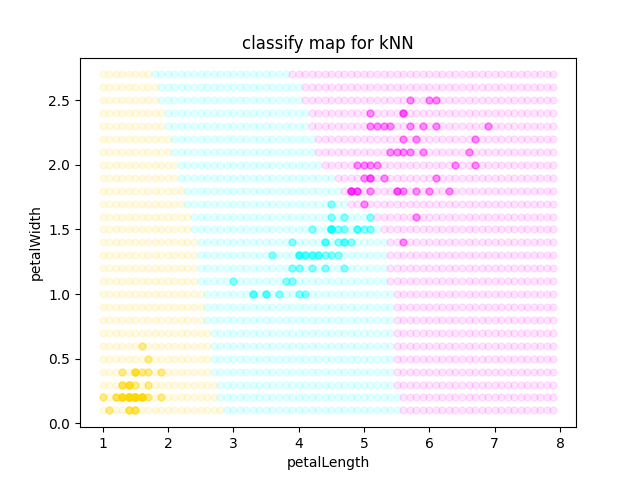

##### Параметры kNN для 4 признаков

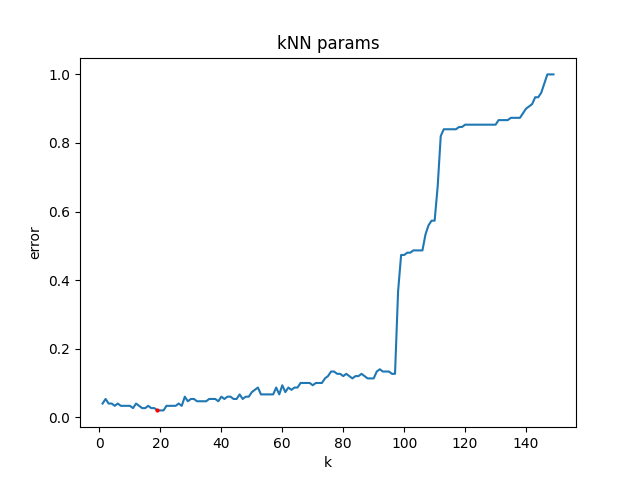

Минимальная ошибка достигается в точке (k = 19, error = 1/50)

#### К взвешенных ближайших соседей

##### Параметры kNNw для 2 признаков и карта классификации

График обучения:

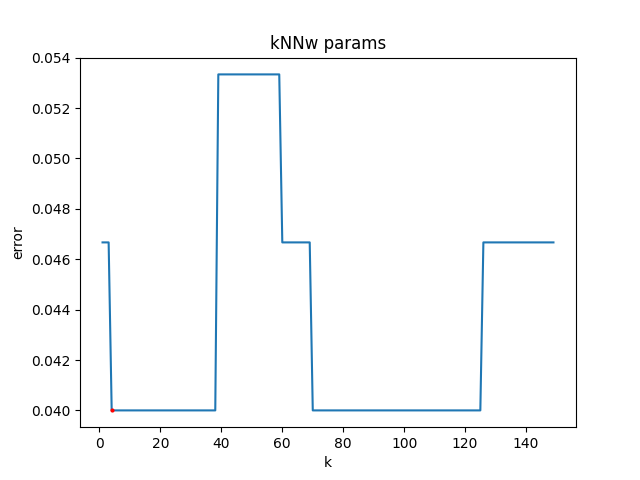

Минимальная ошибка достигается в точке (k = 4, error = 1/25)

Карта классификации при оптимальных параметрах:

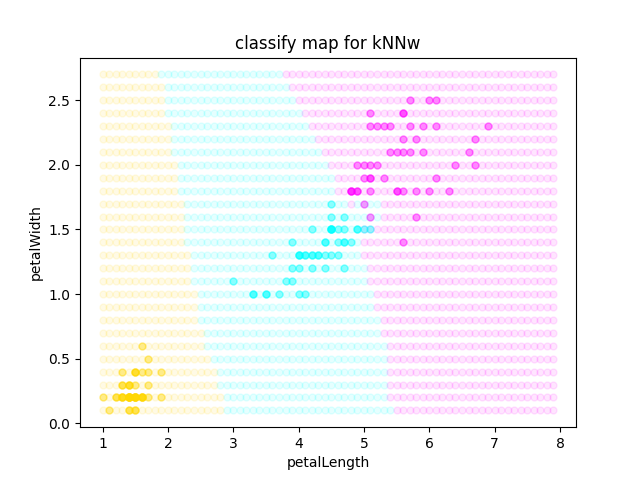

##### Параметры kNNw для 4 признаков

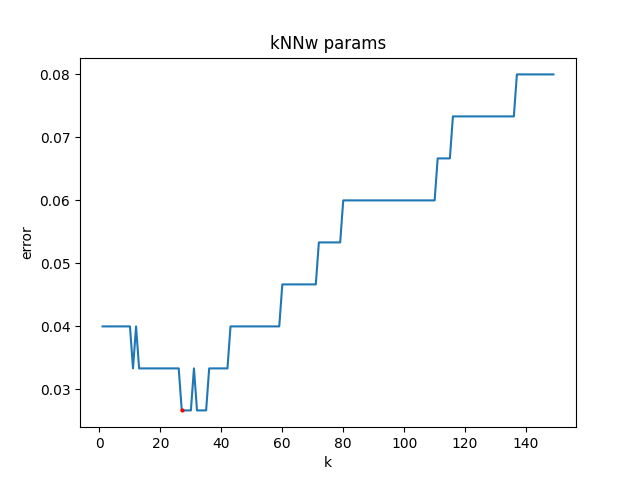

Минимальная ошибка достигается в точке (k = 27, error = 2/75)

#### К взвешенных ближайших соседей с геометрическим весом

##### Параметры kNNw для 2 признаков и карта классификации

График обучения. q проходит от 0 до 1 с шагом 0.05 :

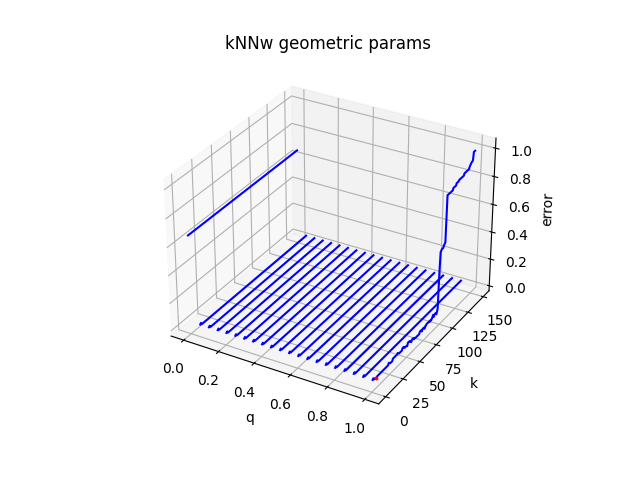

График обучения. q проходит от 0.9 до 1 с шагом 0.001 :

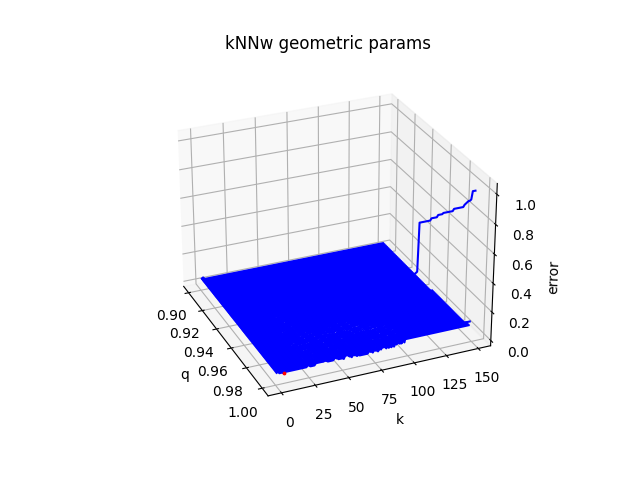

Минимальная ошибка достигается в точке (k = 6, q = 1, error = 1/30)

Карта классификации при оптимальных параметрах:

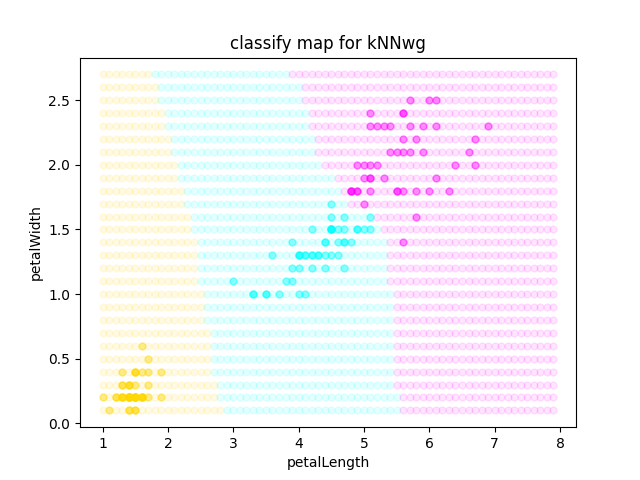

##### Параметры kNN с геометрическим весом для 4 признаков

График обучения. q проходит от 0 до 1 с шагом 0.05 :


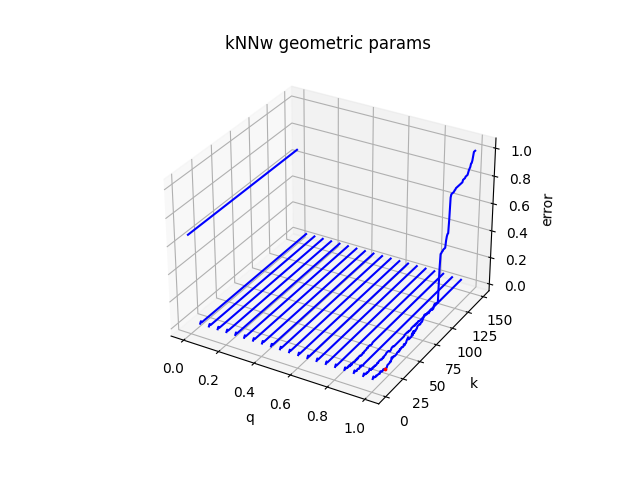

График обучения. q проходит от 0.9 до 1 с шагом 0.001 :



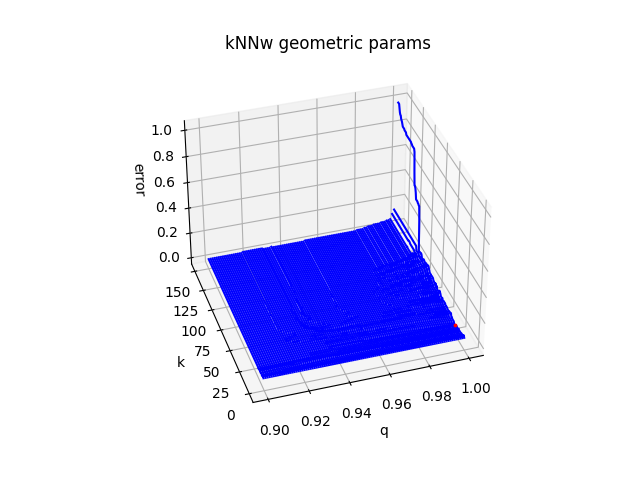

Минимальная ошибка достигается в точке (k = 19, q = 1, error = 1/50)

### Пример данных, при котором взвешенный метод дает лучший результат по сравнению с обычным

Яркость обозначает количество объектов одинаковых объектов

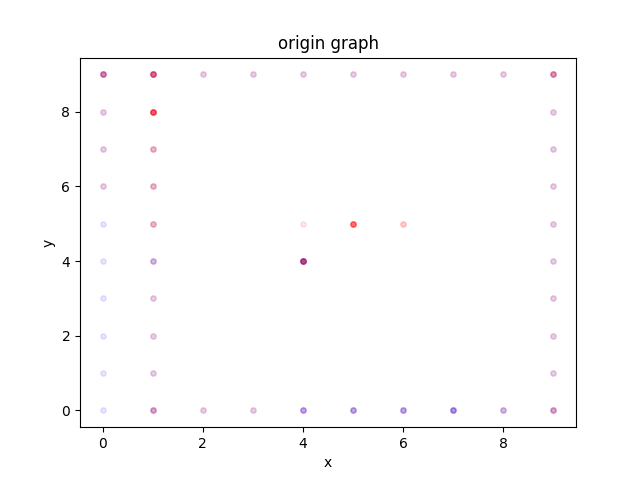

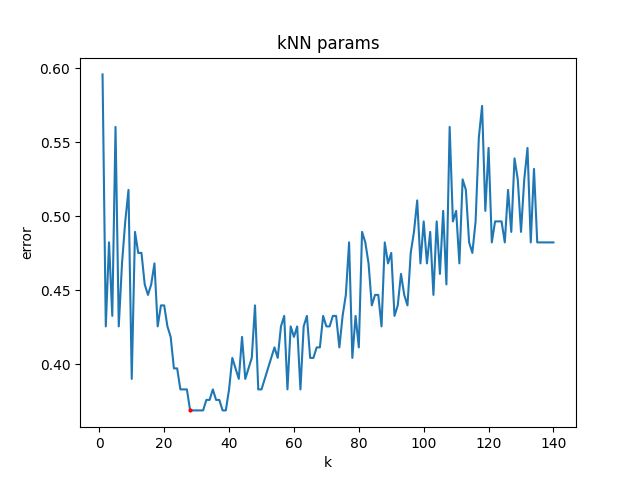

Для kNN точка минимума равна (k = 28, error = 0.3688)

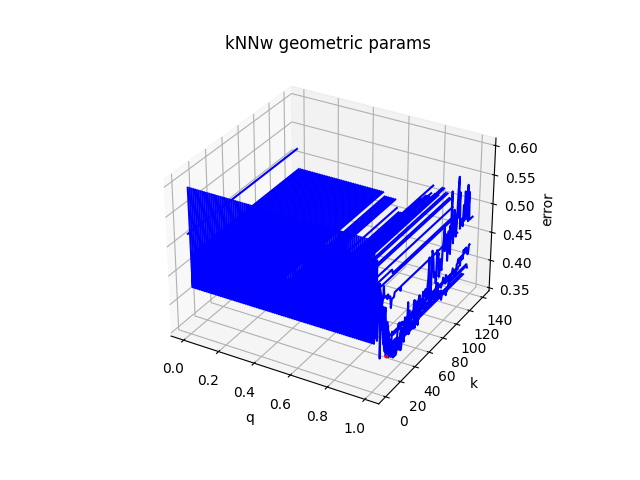

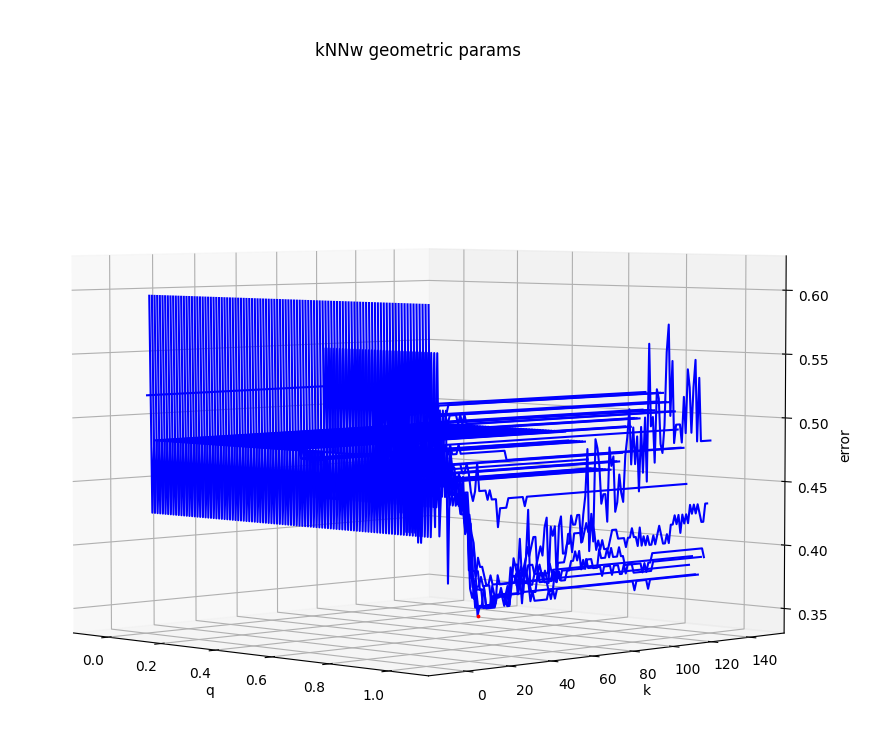

Для kNN с геометрическим весом точка минимума равна (k = 31, q=0.95, error = 0.3617)

Таким образом, на указанных данных, метод с геометрическими весами дает лучший результать по сравнению с единичными весами.

### Вывод

На выбранных данных видно, что лучший результат дает даже самый простой метод ближайших соседей (error=1/30, k=6). Метод с геометрическими весами сходится к этой же ошибке (error=1/30, k=6, q=1). Второй из рассмотренных весов дает хороший, но не лучший результат даже при небольшом количестве соседей (error=1/25, k=4). 
Таким образом для ирисов фишера первенство держит самый простой метод, так как он вычислительно легче геометрического, а результат тот же. Однако это не значит, что такой метод будет хорош всегда. Выборка подтверждающая это приведена выше. 